Тестовое задание
================

## SQL

В *SQLite* файле `issues.db` находится таблица `history`.

Таблица содержит следующие колонки:
* `issue_key` – уникальный ключ задачи
* `status` – статус задачи
* `minutes_in_status` – количество минут, которое задача находилась в статусе
* `previous_status` – предыдущий статус задачи
* `status_begin` – время перехода задачи в текущий статус
* `status_end` – время окончания нахождения задачи в текущем статусе

Время `status_begin` и `ended_at` указаны в формате unix epoch в *миллисекундах*.

In [182]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates


sns.set(style='whitegrid')

In [62]:
# Connecting to the SQLite database
db_path = 'issues.db'
conn = sqlite3.connect(db_path)

query = """SELECT * FROM history LIMIT 5"""
pd.read_sql(query, conn)

,issue_key,status,minutes_in_status,previous_status,status_begin,status_end
0,C-40460,Open,113.0,None,1669363867000,1.669371e+12
1,C-40460,In Progress,6289.0,Open,1669370640119,1.669748e+12
2,C-40460,In Review,2484.0,In Progress,1669747964986,1.669897e+12
3,B-7067,Closed,NaN,Test,1668583633246,NaN
4,B-6168,In Progress,187.0,Open,1655891591619,1.655903e+12


### Задача 1

Напишите SQL запрос, который для всех задач, открытых на момент времени `T`, выведет:
* ключ задачи
* время создания задачи
* статус на момент `T`

Задача считается открытой на момент времени `T`, если к этому времени последний статус задачи был любой кроме `Closed` и `Resolved`.

Оформите запрос таким образом, чтобы, изменив дату, его можно было использовать для поиска открытых задач в любой момент времени как в прошлом, так и в настоящем.

Здесь и далее все даты и времена должны быть переведены в удобочитаемый вид.

In [63]:
query = """
SELECT
    issue_key,
    MIN(DATETIME(status_begin/1000, 'unixepoch')) as creation_time,
    status
FROM history
WHERE
    status_begin <= strftime('%s', '2021-11-12') * 1000
    AND
    (status_end > strftime('%s', '2021-11-12') * 1000 OR status_end is Null)
    AND
    status NOT IN ('Closed', 'Resolved')
GROUP BY
    issue_key
"""
pd.read_sql(query, conn)

,issue_key,creation_time,status
0,A-20577,2019-11-05 09:33:48,Open
1,A-25044,2020-07-13 13:44:24,Open
2,A-27230,2020-10-22 08:40:25,Open
3,A-31053,2020-10-21 15:08:13,Open
4,A-31495,2021-03-19 13:14:12,Open
...,...,...,...
62,E-37393,2021-11-11 20:53:05,In Owl
63,E-38613,2021-11-11 10:09:08,Reopened
64,E-38850,2021-10-07 08:54:20,Open
65,E-39586,2021-11-08 13:56:02,Blocked


## Pandas

Файл `task_history.csv` содержит исторические данные системы сборки (e.g. *jenkins*, *teamcity*, etc.)

Каждая запись в истории описывает отдельный запуск задачи `build_name` на рабочей машине `worker`.<br/>
Для любого запуска известны автор `author` и проект `project`, в рамках которого был запущен расчет данной задачи.

In [78]:
tasks = pd.read_csv('task_history.csv', parse_dates = ['start_time', 'finish_time'])

tasks.head()

,task_id,start_time,finish_time,status,worker,build_name,author,project
0,44973,2005-06-26 09:05:45.716,2005-06-26 09:05:45.997,success,worker_00,test_cyan_texture,Kenny Smith,Halo Anniversary
1,44974,2005-06-26 09:05:46.200,2005-06-26 09:05:46.497,success,worker_01,test_cyan_texture,Kenny Smith,Halo Anniversary
2,44975,2005-06-26 09:05:47.357,2005-06-26 09:06:01.213,success,worker_02,test_cyan_texture,Kenny Smith,Halo Anniversary
3,44977,2005-06-26 09:06:19.273,2005-06-26 09:10:44.734,success,worker_02,test_cyan_texture,Kenny Smith,Halo Anniversary
4,44979,2005-06-26 09:12:00.883,2005-06-26 09:14:29.941,success,worker_04,test_cyan_texture,Kenny Smith,Halo Anniversary


### Задача 2

Для каждой недели распечатайте топ-3 пользователей, потребивших наибольшее количество машиночасов (количество часов, затраченных машиной на обработку задачи).

Выведите для данных пользователей процент потребленных ресурсов от общего объема расчетов за эту неделю.

In [79]:
tasks.shape

(160492, 8)

In [80]:
tasks.duplicated().sum()

0

In [81]:
tasks.isna().sum()

task_id        0
start_time     0
finish_time    0
status         0
worker         0
build_name     0
author         0
project        0
dtype: int64

In [82]:
tasks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160492 entries, 0 to 160491
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   task_id      160492 non-null  int64         
 1   start_time   160492 non-null  datetime64[ns]
 2   finish_time  160492 non-null  datetime64[ns]
 3   status       160492 non-null  object        
 4   worker       160492 non-null  object        
 5   build_name   160492 non-null  object        
 6   author       160492 non-null  object        
 7   project      160492 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 9.8+ MB


In [86]:
tasks.finish_time.describe()

/var/folders/41/fvnr691s2t1glx4r_rv09vww0000gn/T/ipykernel_21155/3122780795.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  tasks.finish_time.describe()


count                         160492
unique                        159251
top       2005-06-20 09:04:18.234000
freq                               4
first     2005-06-20 00:03:20.600000
last      2005-07-18 03:03:11.856000
Name: finish_time, dtype: object

Неделю будем учитывать по времени начала задачи

In [96]:
tasks['week'] = tasks.start_time.dt.isocalendar().week

tasks['time_consumed'] = tasks.finish_time -  tasks.start_time

In [130]:
tasks.head()

,task_id,start_time,finish_time,status,worker,build_name,author,project,week,time_consumed,date
0,44973,2005-06-26 09:05:45.716,2005-06-26 09:05:45.997,success,worker_00,test_cyan_texture,Kenny Smith,Halo Anniversary,25,0 days 00:00:00.281000,2005-06-26
1,44974,2005-06-26 09:05:46.200,2005-06-26 09:05:46.497,success,worker_01,test_cyan_texture,Kenny Smith,Halo Anniversary,25,0 days 00:00:00.297000,2005-06-26
2,44975,2005-06-26 09:05:47.357,2005-06-26 09:06:01.213,success,worker_02,test_cyan_texture,Kenny Smith,Halo Anniversary,25,0 days 00:00:13.856000,2005-06-26
3,44977,2005-06-26 09:06:19.273,2005-06-26 09:10:44.734,success,worker_02,test_cyan_texture,Kenny Smith,Halo Anniversary,25,0 days 00:04:25.461000,2005-06-26
4,44979,2005-06-26 09:12:00.883,2005-06-26 09:14:29.941,success,worker_04,test_cyan_texture,Kenny Smith,Halo Anniversary,25,0 days 00:02:29.058000,2005-06-26


In [129]:
to3_by_week = tasks.groupby([ 'week','author'], as_index = False).time_consumed.sum()\
                    .sort_values(['week','time_consumed'], ascending = [True, False])\
                    .groupby(['week']).head(3)
to3_by_week.head()

,week,author,time_consumed
0,25,Bendy Python,172 days 10:48:37.424000
31,25,Marsha Koltron,17 days 19:39:05.020000
10,25,Java Smoozy,11 days 06:44:32.711000
42,26,Bendy Python,200 days 13:58:23.772000
73,26,Marsha Koltron,31 days 12:49:40.498000


In [165]:
total_consumed_by_week = tasks.groupby('week', as_index = False).time_consumed.sum().rename(columns = {'time_consumed':'weekly_total'})

total_consumed_by_week

,week,weekly_total
0,25,378 days 02:05:33.016000
1,26,517 days 04:27:13.243000
2,27,437 days 10:05:08.459000
3,28,378 days 01:13:38.523000


In [166]:
final = to3_by_week.merge(total_consumed_by_week, on = 'week')

final['percentage_of_total'] = round(final.time_consumed/final.weekly_total*100,2)

final.time_consumed = round(final.time_consumed.dt.total_seconds() / 3600,2)

final.weekly_total = round(final.weekly_total.dt.total_seconds() / 3600,2)

### Топ три авторов потребивших наибольшее количество часов по неделям - 

In [169]:
final

,week,author,time_consumed,weekly_total,percentage_of_total
0,25,Bendy Python,4138.81,9074.09,45.61
1,25,Marsha Koltron,427.65,9074.09,4.71
2,25,Java Smoozy,270.74,9074.09,2.98
3,26,Bendy Python,4813.97,12412.45,38.78
4,26,Marsha Koltron,756.83,12412.45,6.10
5,26,John Ivanov,532.38,12412.45,4.29
6,27,Bendy Python,4257.16,10498.09,40.55
7,27,Java Smoozy,515.10,10498.09,4.91
8,27,Eric Smith,346.35,10498.09,3.30
9,28,Bendy Python,4130.06,9073.23,45.52


### Задача 3

Отобразите график с ежедневным потреблением машинного времени каждым проектом.

In [111]:
tasks['date'] = tasks.start_time.dt.date

tasks.head()

,task_id,start_time,finish_time,status,worker,build_name,author,project,week,time_consumed,date
0,44973,2005-06-26 09:05:45.716,2005-06-26 09:05:45.997,success,worker_00,test_cyan_texture,Kenny Smith,Halo Anniversary,25,0 days 00:00:00.281000,2005-06-26
1,44974,2005-06-26 09:05:46.200,2005-06-26 09:05:46.497,success,worker_01,test_cyan_texture,Kenny Smith,Halo Anniversary,25,0 days 00:00:00.297000,2005-06-26
2,44975,2005-06-26 09:05:47.357,2005-06-26 09:06:01.213,success,worker_02,test_cyan_texture,Kenny Smith,Halo Anniversary,25,0 days 00:00:13.856000,2005-06-26
3,44977,2005-06-26 09:06:19.273,2005-06-26 09:10:44.734,success,worker_02,test_cyan_texture,Kenny Smith,Halo Anniversary,25,0 days 00:04:25.461000,2005-06-26
4,44979,2005-06-26 09:12:00.883,2005-06-26 09:14:29.941,success,worker_04,test_cyan_texture,Kenny Smith,Halo Anniversary,25,0 days 00:02:29.058000,2005-06-26


In [172]:
time_on_project_by_days = tasks.groupby(['project', 'date'], as_index = False).time_consumed.sum()

time_on_project_by_days.time_consumed = time_on_project_by_days.time_consumed.dt.total_seconds()/3600

time_on_project_by_days.head()

,project,date,time_consumed
0,Halo Anniversary,2005-06-20,27.675854
1,Halo Anniversary,2005-06-21,28.652666
2,Halo Anniversary,2005-06-22,22.045459
3,Halo Anniversary,2005-06-23,17.847714
4,Halo Anniversary,2005-06-24,8.555694


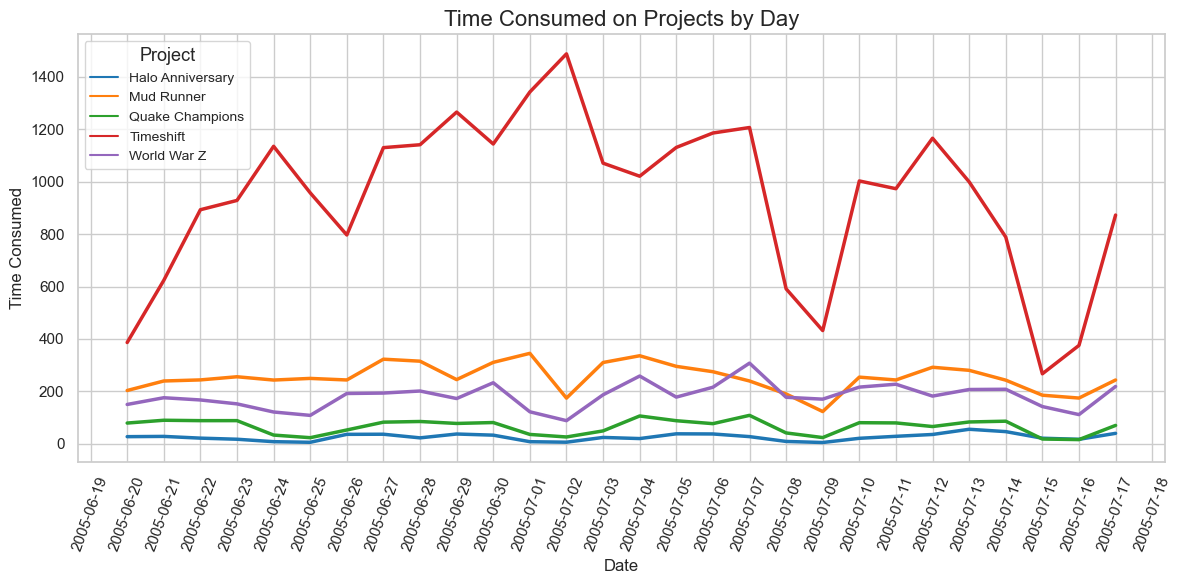

In [181]:
# Creating the plot
plt.figure(figsize=(12, 6))
lineplot = sns.lineplot(data=time_on_project_by_days, x='date', y='time_consumed', hue='project', 
                        palette='tab10', linewidth=2.5)

# Set x-axis to display all dates
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotating date labels for better visibility
plt.xticks(rotation=70)

# Adding labels and title
plt.xlabel('Date', fontsize=12)
plt.ylabel('Time Consumed', fontsize=12)
plt.title('Time Consumed on Projects by Day', fontsize=16)

# Adjusting the legend
plt.legend(title='Project', title_fontsize='13', loc='upper left', fontsize='10')

# Tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

### Задача 4

Рассмотрим *еженедельное* общее потребление ресурсов. На второй неделе можно заметить всплеск нагрузки с ее последующим планомерным снижением.

Проанализируйте предоставленные данные и найдите, с чем связано подобное поведение.